In [1]:
#profitableHospital-project

In [2]:
#dependencies
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import tensorflow
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [3]:
#initial file read
df = pd.read_csv("Medicare_Hospital_Cost_Report_PUF_2017.csv")
df.head()

C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (105) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,County,Medicare CBSA Number,Rural Versus Urban,CCN Facility Type,...,Total Other Income,Total Income,Total Other Expenses,Net Income,Cost To Charge Ratio,Net Revenue from Medicaid,Medicaid Charges,Net Revenue from Stand-Alone SCHIP,Stand-Alone SCHIP Charges,rpt_rec_num
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,MARSHALL,48540.0,U,STH,...,4492364.0,2638799.0,NaN,2638799.0,0.453498,1237912.0,4026663.0,NaN,NaN,599181
1,340106,SANDHILLS REGIONAL MEDICAL CENTER,1000 WEST HAMLET AVE,HAMLET,NC,28345,RICHMOND,99934.0,R,STH,...,31174.0,-1114660.0,NaN,-1114660.0,0.173114,391215.0,4981119.0,NaN,NaN,601095
2,450178,PECOS COUNTY MEMORIAL HOSPITAL,386 W IH-10,FORT STOCKTON,TX,79735,PECOS,99945.0,R,STH,...,2096862.0,576278.0,NaN,576278.0,0.455741,719760.0,1275211.0,NaN,NaN,601392
3,341317,PIONEER HLTH SERV OF STOKES CNTY,1570 NC & 89 HWY,DANBURY,NC,27016,STOKES,49180.0,U,CAH,...,1542201.0,640268.0,622592.0,17676.0,1.154767,578366.0,801800.0,159516.0,702117.0,601721
4,110003,MAYO CLINIC HEALTH SYSTEM WAYCROSS,1900 TEBEAU STREET,WAYCROSS,GA,31501,WARE,99911.0,R,STH,...,224757.0,-6170184.0,NaN,-6170184.0,0.271734,3113423.0,11231324.0,1331.0,8211.0,603846


In [4]:
conTable = pd.read_csv("certificateofneedstatesTable.csv")
conTable.head()

,State Code,CON
0,AK,1
1,AL,1
2,AR,1
3,AZ,0
4,CA,0


In [5]:
urbanTable = pd.read_csv("ruralversusurbanTable.csv")
urbanTable.head()

,Rural Versus Urban,Urban
0,U,1
1,R,0


In [6]:
# ... Add additional data = Certificate of Need & Urban Indicators

In [7]:
#Append certificate of need indicator
mainFile1 = pd.merge(df, conTable, how= "left", on=['State Code'])
#mainFile1.head()

In [8]:
#Append a numeric representation of rural v. urban
mainFile2 = pd.merge(mainFile1, urbanTable, how= "left", on=['Rural Versus Urban'])
#mainFile2.head()

In [9]:
# ... Add calculated fields

In [10]:
#Append calculated field inpatient percent
inpatient = mainFile2["Inpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Inpatient %"] = inpatient
#mainFile2.head()

In [11]:
#Append calculated field outpatient percent
outpatient = mainFile2["Outpatient Revenue"]/mainFile2["Gross Revenue"]
mainFile2["Outpatient %"] = outpatient
#mainFile2.head()

In [12]:
#Append calculated field charity percent
charity = mainFile2["Cost of Charity Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Charity %"] = charity
#mainFile2.head()

In [13]:
#Append calculated field uncompensated percent
uncompensated = mainFile2["Cost of Uncompensated Care"]/mainFile2["Net Patient Revenue"]
mainFile2["Uncompensated %"] = charity
#mainFile2.head()

In [14]:
#Append calculated field revenue per discharge
revdischarge = mainFile2["Net Patient Revenue"]/mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]
mainFile2["Rev Per Discharge"] = revdischarge
#mainFile2.head()

In [15]:
#Append calculated field revenue per bed
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Number of Beds"]
mainFile2["Rev Per Bed"] = revbed
#mainFile2.head()

In [16]:
#Append calculated field revenue per bed day
revbed = mainFile2["Net Patient Revenue"]/mainFile2["Total Bed Days Available"]
mainFile2["Rev Per Bed Days"] = revbed
#mainFile2.head()

In [17]:
#Append calculated field revs per fte
revfte = mainFile2["Net Patient Revenue"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Rev Per FTE"] = revfte
#mainFile2.head()

In [18]:
#Append calculated field discharges per bed
volbed = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Number of Beds"]
mainFile2["Discharges Per Bed"] = volbed
#mainFile2.head()

In [19]:
#Append calculated field discharges per bed day
voldays = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["Total Bed Days Available"]
mainFile2["Discharges Per Bed Days"] = voldays
#mainFile2.head()

In [20]:
#Append calculated field discharges per bed
volfte = mainFile2["Total Discharges (V + XVIII + XIX + Unknown)"]/mainFile2["FTE - Employees on Payroll"]
mainFile2["Discharges Per FTE"] = volbed
#mainFile2.head()

In [21]:
#labor percent
wagepercent = mainFile2["Wage-Related Costs (Core)"] + mainFile2["Total Salaries (adjusted)"]
wagepercent = wagepercent / mainFile2["Net Patient Revenue"]
mainFile2["Labor %"] = wagepercent
#wagepercent.head()

In [22]:
#Overhead percent
overheadpercent = mainFile2["Overhead Non-Salary Costs"] / mainFile2["Net Patient Revenue"]
mainFile2["Overhead %"] = overheadpercent
#overheadpercent.head()

In [23]:
#Depreciation percent
deprpercent = mainFile2["Depreciation Cost"] / mainFile2["Net Patient Revenue"]
mainFile2["Depreciation %"] = deprpercent
#overheadpercent.head()

In [24]:
#Append calculated field net income percent to file
profit = mainFile2["Net Income"]/mainFile2["Net Patient Revenue"]
mainFile2["Net Income %"] = profit
#mainFile2.head()

In [25]:
# Review net income percent for outlier reduction approach
netinc = mainFile2["Net Income %"]
netinc.head()

0    0.308395
1   -0.337043
2    0.232354
3    0.002665
4   -0.132444
Name: Net Income %, dtype: float64

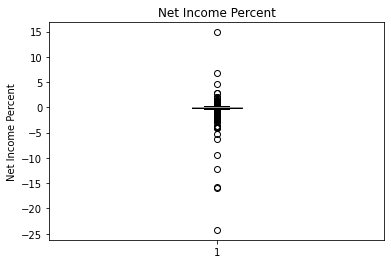

In [26]:
# Box plot and outlier calculations for outlier approach
netinc2 = netinc.dropna(how='any')
chartdata = netinc2
fig1, ax1 = plt.subplots()
ax1.set_title('Net Income Percent')
ax1.set_ylabel('Net Income Percent')
ax1.boxplot(chartdata)
plt.show()

In [27]:
#Quartile calculations
quartiles = chartdata.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of profit percent is: {lowerq}")
print(f"The upper quartile of profit percent is: {upperq}")
print(f"The interquartile range of profit percent is: {iqr}")
print(f"The the median of profit percent is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of profit percent is: -0.030653238847723918
The upper quartile of profit percent is: 0.11379730445563284
The interquartile range of profit percent is: 0.14445054330335677
The the median of profit percent is: 0.0380451602645128 
Values below -0.24732905380275907 could be outliers.
Values above 0.330473119410668 could be outliers.


In [28]:
#Create a bronze, silver, gold score for clasifying net income performance
bins = [-100, -0.03065, 0.11379, 100]
group_names = ["3", "2", "1"]

In [29]:
#Add a bronze, silver, gold scoring system to the dataset
mainFile2["Net Income Score"] = pd.cut(mainFile2["Net Income %"], bins, labels=group_names, include_lowest=True)
#mainFile2.head()

In [30]:
#Quick check on distribution of bronze, silver and gold
mainFile2['Net Income Score'].value_counts()

2    2945
1    1473
3    1473
Name: Net Income Score, dtype: int64

In [82]:
# ..... File targeting

In [167]:
mainFile3 = mainFile2

In [168]:
#Targets dataset on Colorad0
#mainFile3 = mainFile3.loc[df['State Code'] == 'CO']

In [169]:
#Targets dataset on certificate of need states
mainFile3 = mainFile3.loc[mainFile2['CON'] == 1]

In [170]:
#Remove net income outliers
mainFile3 = mainFile3.loc[mainFile2['Net Income %'] <= .3304]

In [171]:
#Remove net income outliers
mainFile3 = mainFile3.loc[mainFile2['Net Income %'] >= -.2473]

In [172]:
#Remove Rev Per Bed outliers
mainFile3 = mainFile3.loc[mainFile2['Rev Per Bed'] <= 2000000]

In [173]:
#Remove Rev Per FTE outliers
mainFile3 = mainFile3.loc[mainFile2['Rev Per FTE'] <= 500000]

In [174]:
#Remove Rev Per Discharge outliers
mainFile3 = mainFile3.loc[mainFile2['Rev Per Discharge'] <= 175000]

In [175]:
#Targets dataset on STH locations
mainFile3 = mainFile3.loc[mainFile2['CCN Facility Type'] == 'STH']

In [176]:
#Quick check on distribution of bronze, silver and gold
mainFile3['Net Income Score'].value_counts()

2    1039
1     402
3     389
Name: Net Income Score, dtype: int64

In [177]:
mainFile4 = mainFile3

In [178]:
mainFile4.to_csv("mainCO2017.csv", index=False, header=True)

In [179]:
#Targeting the dataset on metrics important to Kent
targetFile5 = mainFile4[['Provider CCN','Hospital Name','Street Address','City','State Code','Zip Code','CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev Per Discharge','Rev Per Bed','Rev Per Bed Days','Rev Per FTE','Discharges Per Bed','Discharges Per Bed Days','Discharges Per FTE','Net Income %', 'Net Income Score', 'Labor %', 'Overhead %', 'Depreciation %']]
targetFile5.head()


,Provider CCN,Hospital Name,Street Address,City,State Code,Zip Code,CON,Urban,Inpatient %,Outpatient %,...,Rev Per Bed Days,Rev Per FTE,Discharges Per Bed,Discharges Per Bed Days,Discharges Per FTE,Net Income %,Net Income Score,Labor %,Overhead %,Depreciation %
0,510013,REYNOLDS MEMORIAL HOSPITAL,800 WHEELING AVENUE,GLEN DALE,WV,26038,1.0,1.0,0.311881,0.688119,...,1328.657453,26564.899100,6.214286,0.067547,6.214286,0.308395,1,0.715116,0.627406,0.031451
4,110003,MAYO CLINIC HEALTH SYSTEM WAYCROSS,1900 TEBEAU STREET,WAYCROSS,GA,31501,1.0,0.0,0.391293,0.608707,...,2504.689677,50452.385233,13.612903,0.113441,13.612903,-0.132444,3,0.501340,0.734530,NaN
5,250025,GILMORE MEMORIAL REGIONAL MEDICAL CE,1105 EARL FRYE BLVD,AMORY,MS,38821,1.0,0.0,0.364763,0.635237,...,1105.503158,52406.586826,8.589474,0.071579,8.589474,-0.132426,3,0.414191,0.826683,0.119266
7,380029,SILVERTON HOSPITAL,342 FAIRVIEW STREET,SILVERTON,OR,97381-1993,1.0,1.0,0.347411,0.652589,...,5590.331158,70460.869126,29.625000,0.162775,29.625000,-0.050419,3,0.734931,0.533090,0.031444
8,140191,INGALLS MEMORIAL HOSPITAL,ONE INGALLS DRIVE,HARVEY,IL,60426,1.0,1.0,0.364419,0.635581,...,3100.185884,156208.119555,34.283582,0.125581,34.283582,0.080314,2,0.409350,0.670235,0.060069


In [180]:
# Identify incomplete rows
targetFile5.count()

Provider CCN               1830
Hospital Name              1830
Street Address             1829
City                       1830
State Code                 1830
Zip Code                   1830
CON                        1830
Urban                      1830
Inpatient %                1829
Outpatient %               1821
Charity %                  1714
Uncompensated %            1714
Rev Per Discharge          1830
Rev Per Bed                1830
Rev Per Bed Days           1830
Rev Per FTE                1830
Discharges Per Bed         1830
Discharges Per Bed Days    1830
Discharges Per FTE         1830
Net Income %               1830
Net Income Score           1830
Labor %                    1830
Overhead %                 1830
Depreciation %             1819
dtype: int64

In [181]:
targetFile5 = targetFile5.dropna(how='any')

In [182]:
# Identify incomplete rows
targetFile5.count()

Provider CCN               1695
Hospital Name              1695
Street Address             1695
City                       1695
State Code                 1695
Zip Code                   1695
CON                        1695
Urban                      1695
Inpatient %                1695
Outpatient %               1695
Charity %                  1695
Uncompensated %            1695
Rev Per Discharge          1695
Rev Per Bed                1695
Rev Per Bed Days           1695
Rev Per FTE                1695
Discharges Per Bed         1695
Discharges Per Bed Days    1695
Discharges Per FTE         1695
Net Income %               1695
Net Income Score           1695
Labor %                    1695
Overhead %                 1695
Depreciation %             1695
dtype: int64

In [183]:
#Output targeted file
targetFile5.to_csv("targetedCO2017.csv", index=False, header=True)

In [184]:
# ... Net Income to feature review

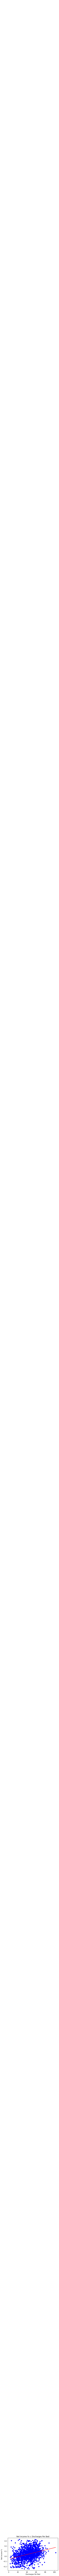

The correlation coefficient is 0.33
The line equation is as follows:  y = 0.0x + -0.05


In [185]:
#NI v. discharges per bed
x_axis = targetFile5["Discharges Per Bed"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Discharges Per Bed")
plt.xlabel("Discharges Per Bed")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

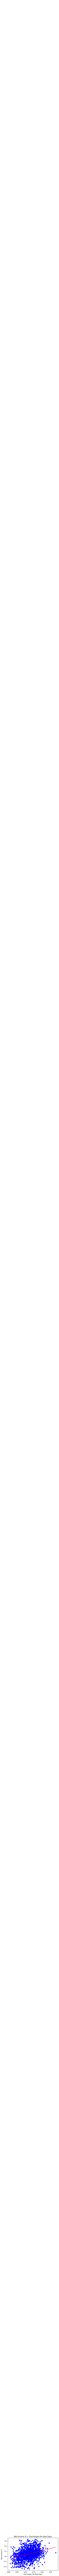

The correlation coefficient is 0.34
The line equation is as follows:  y = 0.84x + -0.06


In [186]:
#NI v. discharges per bed days
x_axis = targetFile5["Discharges Per Bed Days"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Discharges Per Bed Days")
plt.xlabel("Discharges Per Bed Days")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

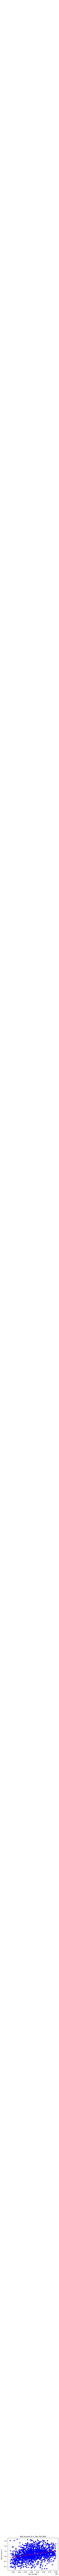

The correlation coefficient is 0.32
The line equation is as follows:  y = 0.0x + -0.04


In [187]:
#NI v. Revenue Per Bed
x_axis = targetFile5["Rev Per Bed"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Rev Per Bed")
plt.xlabel("Rev Per Bed")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

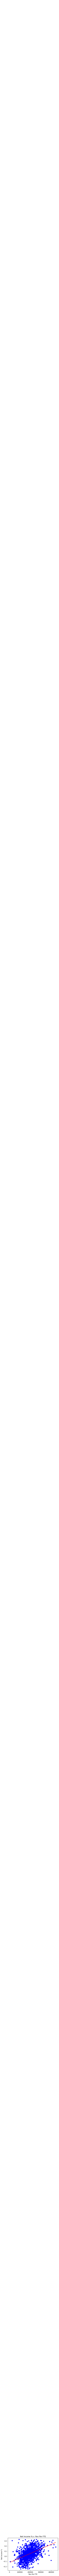

The correlation coefficient is 0.47
The line equation is as follows:  y = 0.0x + -0.12


In [188]:
#NI v. Rev Per FTE
x_axis = targetFile5["Rev Per FTE"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Rev Per FTE")
plt.xlabel("Rev Per FTE")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

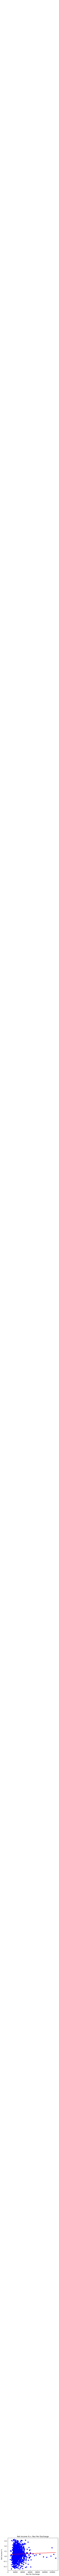

The correlation coefficient is 0.03
The line equation is as follows:  y = 0.0x + 0.03


In [189]:
#NI v. Rev Per Discharge
x_axis = targetFile5["Rev Per Discharge"]
y_axis = targetFile5["Net Income %"]
plt.title("Net Income % v. Rev Per Discharge")
plt.xlabel("Rev Per Discharge")
plt.ylabel("Net Income %")
plt.scatter(x_axis, y_axis, marker="o", color="blue")
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="red")
#plt.savefig("3bchart_days2unemployment_k.png")
plt.show()
print(f"The correlation coefficient is {round(st.pearsonr(x_axis,y_axis)[0],2)}")
print(f"The line equation is as follows:  {line_eq}")

In [190]:
#Start machine learning ...

In [191]:
# Select features to be used as x values
features1 = targetFile5[['CON','Urban','Inpatient %','Outpatient %','Charity %','Uncompensated %','Rev Per Discharge','Rev Per Bed','Rev Per Bed Days','Rev Per FTE','Discharges Per Bed','Discharges Per Bed Days','Discharges Per FTE','Labor %','Overhead %', 'Depreciation %']]
features1.head()

,CON,Urban,Inpatient %,Outpatient %,Charity %,Uncompensated %,Rev Per Discharge,Rev Per Bed,Rev Per Bed Days,Rev Per FTE,Discharges Per Bed,Discharges Per Bed Days,Discharges Per FTE,Labor %,Overhead %,Depreciation %
0,1.0,1.0,0.311881,0.688119,0.003080,0.003080,19670.239080,1.222365e+05,1328.657453,26564.899100,6.214286,0.067547,6.214286,0.715116,0.627406,0.031451
5,1.0,0.0,0.364763,0.635237,0.000905,0.000905,15444.529412,1.326604e+05,1105.503158,52406.586826,8.589474,0.071579,8.589474,0.414191,0.826683,0.119266
7,1.0,1.0,0.347411,0.652589,0.040733,0.040733,34343.975387,1.017440e+06,5590.331158,70460.869126,29.625000,0.162775,29.625000,0.734931,0.533090,0.031444
8,1.0,1.0,0.364419,0.635581,0.042945,0.042945,24686.765346,8.463507e+05,3100.185884,156208.119555,34.283582,0.125581,34.283582,0.409350,0.670235,0.060069
9,1.0,0.0,0.513304,0.486696,0.017442,0.017442,18032.723164,1.209012e+05,1328.584749,44957.982957,6.704545,0.073676,6.704545,0.386781,0.660867,0.053282


In [192]:
#Output features file as a reference document
features1.to_csv("featuresCO2017.csv", index=False, header=True)

In [222]:
# ... Linear Regression Model

In [194]:
# Identify the outcome column/data
y = targetFile5[['Net Income %']]
y.head()

,Net Income %
0,0.308395
5,-0.132426
7,-0.050419
8,0.080314
9,-0.091644


In [195]:
targetFile5["Net Income %"].dtype

dtype('float64')

In [196]:
y.shape

(1695, 1)

In [197]:
X = features1
X.shape

(1695, 16)

In [198]:
#Create a training and testing dataset - one hot
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1)

In [199]:
y_train.shape

(1271, 1)

In [200]:
X_train.shape

(1271, 16)

In [201]:
y_test.shape

(424, 1)

In [202]:
X_test.shape

(424, 16)

In [203]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [207]:
#Create the linear regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LinearRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.366611970432292


In [208]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: -0.1059715732160067


In [ ]:
# ... Recursive Feature Elimination

In [204]:
#Identify features to create a more efficient model with
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X_train_scaled, y_train)

In [205]:
selector.support_

array([False, False, False, False, False, False, False,  True,  True,
       False,  True,  True, False, False,  True, False])

In [206]:
selector.ranking_

array([12, 11,  7,  9,  8, 10,  6,  1,  1,  4,  1,  1,  3,  2,  1,  5])

In [ ]:
# ... Logistics Model

In [209]:
# Identify the outcome column/data
yy = targetFile5[['Net Income Score']]
yy.head()

,Net Income Score
0,1
5,3
7,3
8,2
9,3


In [211]:
yy.shape

(1695, 1)

In [212]:
XX = features1
XX.shape

(1695, 16)

In [213]:
#Create a training and testing dataset - one hot
X_train, X_test, y_train, y_test = train_test_split(
    XX, yy, random_state=1)

In [215]:
y_train.shape

(1271, 1)

In [216]:
X_train.shape

(1271, 16)

In [217]:
y_test.shape

(424, 1)

In [218]:
y_test.shape

(424, 1)

In [219]:
# Scale your data
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [220]:
#Create the logistic regression model and fit to the training data
#score is r2 root mean ... 1 is better
modela = LogisticRegression()
modela.fit(X_train_scaled, y_train)
score = modela.score(X_train_scaled, y_train)
print(f"Training Data Score: {modela.score(X_train_scaled, y_train)}")

Training Data Score: 0.6428009441384737


C:\Users\rodge\anaconda3\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [221]:
#Run the model with the testing data and determine score
print(f"Testing Data Score: {modela.score(X_test_scaled, y_test)}")

Testing Data Score: 0.6721698113207547
